**Цель работы**

Изучить принципы построение однослойных и многослойных нейросетей в фреймворке pytorch, а также обучить модели для апроксимации исходной функции. Создать и обучить модель нейросети с помощью фреймворка pytorch для предсказания целевого параметра.

**Ход работы**

37. $f(x, y) = \dfrac{1}{|x|+ 4} + \dfrac{3}{y2+ 4}$

*Импорт библиотек*

In [ ]:
import torch
from torch.nn import Sequential, Linear, Sigmoid, Tanh, ReLU, PReLU, L1Loss, MSELoss
import matplotlib.pyplot as plt
from matplotlib import cm
import tqdm

**Архитектура нейронной сети**

$$NN(X) = U\psi (V\cdot\phi(W\cdot X+B) + C) + d=\left(
  \begin{array}{ccc}
  \dots & \dots & \dots \\
  \dots & u_r\psi\left(\sum\limits_{i=1}^{k}v_{ri}\phi\left(\sum\limits_{l=1}^{n}w_{il}x_{lp} + b_{i}\right) +c_r\right) + d  & \dots \\
  \dots & \dots & \dots \\
  \end{array}
  \right)
   $$

**Задаем модель**

In [ ]:
model = Sequential(
    Linear(2, 8), # W * X + B
    Tanh(), # ф(..)
    Linear(8, 11), # V * ф(..) + С
    Tanh(), # t(..)
    Linear(11, 1) # U * t(..) + D
)

**Инициализируем наш датасет**

In [ ]:
def f(x, y):
    return 1/(abs(x) + 4) + 3/(y**2+4)

<class 'torch.Tensor'>


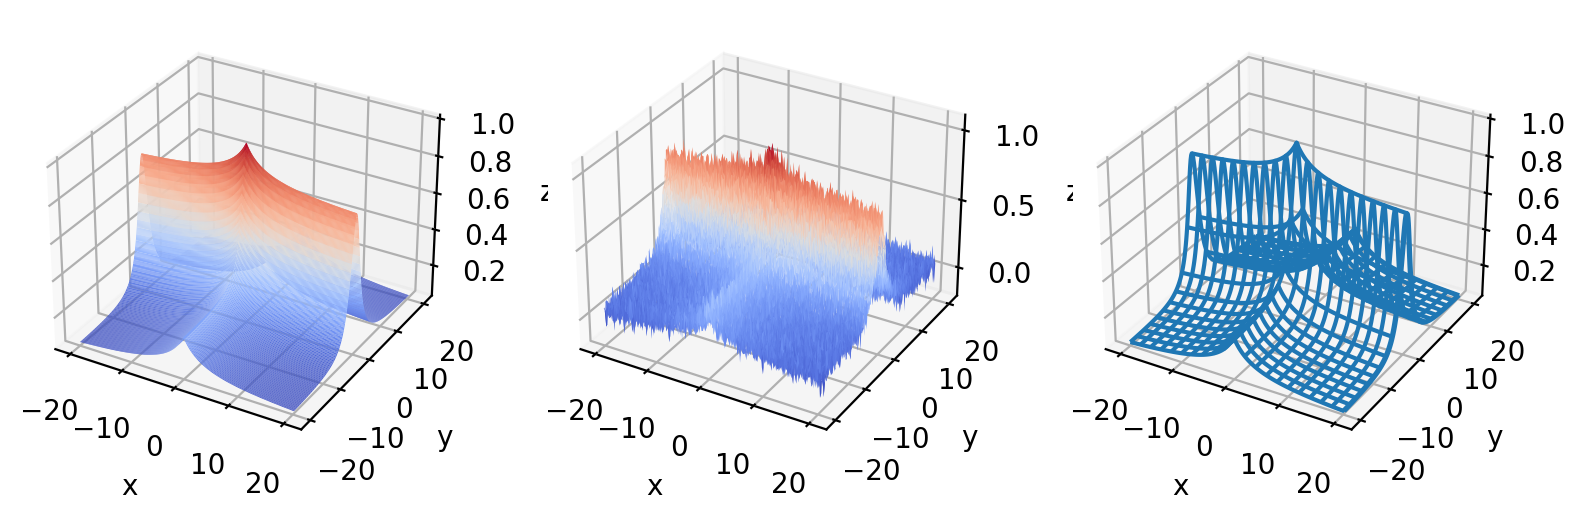

In [ ]:
X = torch.arange(-20, 20.25, 0.2)
Y = torch.arange(-20, 20.25, 0.2)
X, Y = torch.meshgrid(X, Y, indexing='xy')

Z = f(X,Y)

fig = plt.figure(figsize=plt.figaspect(0.5), dpi=200)

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

noise = torch.randn(Z.shape) / 20 # генерация шумов
Z_noise = Z + noise
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot_surface(X, Y, Z_noise, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax = fig.add_subplot(1, 3, 3, projection='3d')

ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

print(type(Z))

In [ ]:
X1, Y1 = X.flatten(), Y.flatten() # приводим к одномерному массиву
Z1 = f(X1, Y1)
noise = torch.randn(Z1.shape) / 20 # генерация шумов
Z1 = Z1 #+ noise

In [ ]:
Xd = torch.stack([X1, Y1], dim=1)
Xd.shape

torch.Size([40804, 2])

In [ ]:
Zd = Z1.reshape(-1, 1)
Zd.shape

torch.Size([40804, 1])

**Тренировка модели**

*Определение места выполнения*

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


*Оптимизатор*

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

*Обучение*

In [ ]:
batch_size = 100 # Размер батча

loss = L1Loss(reduction = 'mean')
loss_dt = loss(model.forward(Xd), Zd) # посчитаем первоначальный лосс
epoch = 0 # Эпоха
check_optim = False # регулировка скорости обучения

model.to(device) # переводим модель на нужный нам девайс

while loss_dt.item() > 0.000406: # 0.0015:
    epoch += 1
    order = torch.randperm(Xd.shape[0]) # перемешиваем значения на входе

    for start_index in range(0, Xd.shape[0], batch_size):

        optimizer.zero_grad() # обнуляем градиент
        batch_indexes = order[start_index:start_index+batch_size] # берем индексы для батча

        if batch_indexes.shape[0] !=batch_size:
            break

        # Выбираем батч
        x_batch = Xd[batch_indexes].to(device)
        z_batch = Zd[batch_indexes].to(device)

        z_pred = model.forward(x_batch) # предсказание

        loss_value = loss(z_pred, z_batch) # считаем лосс
        loss_value.backward() # считаем градиент

        if not check_optim and epoch > 50:
            check_optim = True
            for g in optimizer.param_groups:
                g['lr'] = 1.0e-3

        optimizer.step() # делаем шаг градиента

    test_preds = model.forward(Xd)
    loss_dt = loss(test_preds, Zd)

    if epoch % 100 == 0:
        print(loss_dt)

    # Выход, если прям точность упирается в потолок
    if epoch > 10000:
        break

tensor(0.0016, grad_fn=<L1LossBackward0>)


KeyboardInterrupt: 

In [ ]:
model.eval()
model.to("cpu")

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=11, bias=True)
  (3): Tanh()
  (4): Linear(in_features=11, out_features=1, bias=True)
)

**Предсказание**

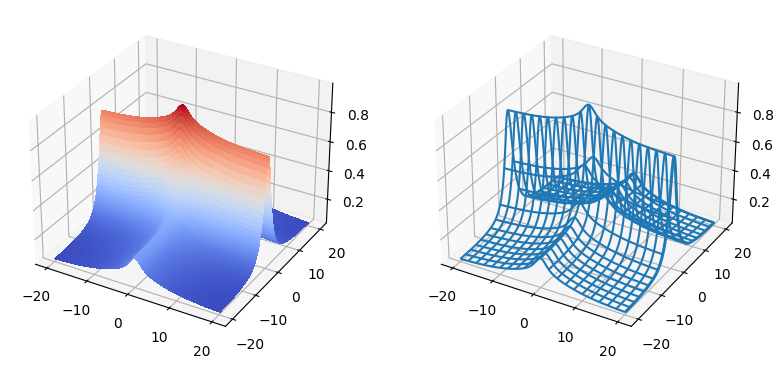

In [ ]:
fig_2 = plt.figure(figsize=plt.figaspect(0.5))

ax_2 = fig_2.add_subplot(1, 2, 1, projection='3d')
X = torch.arange(-20, 20.25, 0.2)
Y = torch.arange(-20, 20.25, 0.2)

# Z = z.test(np.array([X,Y]))
X, Y = torch.meshgrid(X, Y, indexing='xy')

Z = model.forward(Xd).detach().numpy().reshape(202, 202)

ax_2.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax_2 = fig_2.add_subplot(1, 2, 2, projection='3d')

ax_2.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

**Сохранение модели в файл**

In [ ]:
# model.eval()
is_save = False
if is_save:
    torch.save(model, "./models_lab3/model37.pt")
    # torch.save(model.state_dict(), "./models_lab3/model37.pt")

In [ ]:
model_from_file = torch.load("./models_lab3/model37.pt")
# model_from_file = model(*args, **kwargs) # model - нужно название класса
# model_from_file.load_state_dict(torch.load("./models_lab3/model37.pt"))

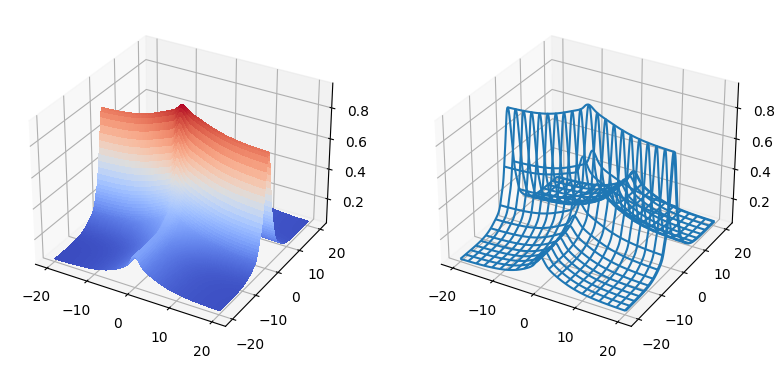

In [ ]:
fig_2 = plt.figure(figsize=plt.figaspect(0.5))

ax_2 = fig_2.add_subplot(1, 2, 1, projection='3d')
X = torch.arange(-20, 20.25, 0.2)
Y = torch.arange(-20, 20.25, 0.2)

# Z = z.test(np.array([X,Y]))
X, Y = torch.meshgrid(X, Y, indexing='xy')

Z = model_from_file.forward(Xd).detach().numpy().reshape(202, 202)

ax_2.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax_2 = fig_2.add_subplot(1, 2, 2, projection='3d')

ax_2.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

Нейросеть успешно апроксимировала исходную функцию

*Импорт библиотек*

In [159]:
# Обучение
import torch
from torch.nn import Sequential, Linear, Sigmoid, Tanh, ReLU, GELU, ELU, PReLU, L1Loss, MSELoss
from sklearn.metrics import r2_score

# Работа с данными
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
from matplotlib import cm
from torch.utils.tensorboard import SummaryWriter
import tqdm

import matplotlib.pyplot as plt # Строим графики
import seaborn as sns # Для визуализации данных

**Архитектура нейронной сети**

$$NN(X) = U\psi (V\cdot\phi(W\cdot X+B) + C) + d=\left(
  \begin{array}{ccc}
  \dots & \dots & \dots \\
  \dots & u_r\psi\left(\sum\limits_{i=1}^{k}v_{ri}\phi\left(\sum\limits_{l=1}^{n}w_{il}x_{lp} + b_{i}\right) +c_r\right) + d  & \dots \\
  \dots & \dots & \dots \\
  \end{array}
  \right)
   $$

**Задаем модель**

In [160]:
model = Sequential(
    # Linear(6,48), # W * X + B
    Linear(6,24), # W * X + B
    PReLU(), # ф(..)
    Linear(24, 18), # V * ф(..) + С
    PReLU(), # t(..)
    Linear(18, 1), # U * t(..) + D
)

*Определение места выполнения*

In [161]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


**Инициализируем наш датасет**

In [162]:
dataset = pd.read_csv("Кузин Мирослав.csv")

In [163]:
del dataset['Unnamed: 0']
print(dataset.head())

   X_0        X_1       X_2       X_3       X_4       X_5            Y
0    0   0.691698  7.858499  0.580230  5.905468  3.915474  1001.483550
1    0  10.193619  4.666148  0.738021  3.076891 -0.306504  1088.264357
2    0   6.567007  2.522726  2.427208  5.155961  1.170255  1037.565265
3    0  12.438537  2.312052  2.578829  5.970600  1.776357  1179.061522
4    0   6.063214  6.200398  0.194858  6.456120 -1.831541  1047.361595


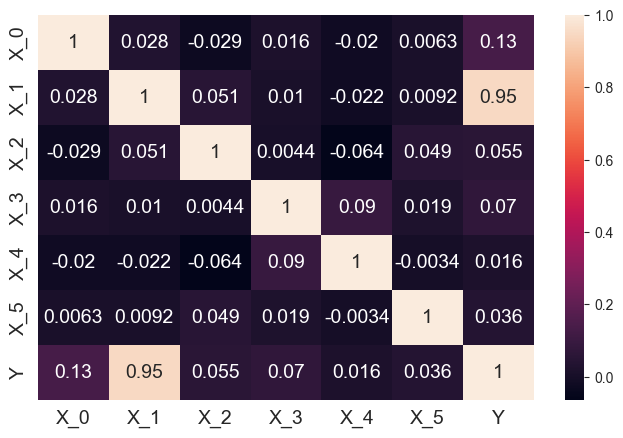

In [164]:
# Визуализируем матрицу с помощью библиотки seaborn
plt.figure(figsize = (8, 5))
sns.heatmap(dataset.corr(), annot=True, annot_kws={"size": 14})
sns.set_style("white")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

**Цель работы**

Изучить принципы построение однослойных и многослойных нейросетей в фреймворке pytorch, а также обучить модели для апроксимации исходной функции.

**Ход работы**

*Импорт библиотек*

In [165]:
train_tensor = torch.tensor(dataset.values[:, :dataset.values.shape[1] - 1])
# train_tensor = torch.tensor(dataset.values[:, (0, 2, 3, 4, 5)])
target_tensor = torch.tensor(dataset.values[:, -1])

print(train_tensor.shape)
print(target_tensor.shape)

torch.Size([900, 6])
torch.Size([900])


In [166]:
train_size = train_tensor.shape[1] # размер тренировочного датасета (все характеристики кроме последней, последняя - target(Y))
print(train_size)

X_train, X_test, y_train, y_test = train_test_split(
    train_tensor,
    target_tensor,
    test_size=0.2,
    shuffle=True)

# Изменим размерность под нейросеть для target значений
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

X_train = X_train.to(device=device, dtype=torch.float64)
y_train.to(device=device, dtype=torch.float64)
X_test = X_test.to(device=device, dtype=torch.float64)
y_test.to(device=device, dtype=torch.float64)

# print(X_train)

# Проверим размерность
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

6
torch.Size([720, 6])
torch.Size([720, 1])
torch.Size([180, 6])
torch.Size([180, 1])


*Нормализация*

In [167]:
# min_max_scaler = MinMaxScaler() # Создаем объект для нормализации
# X_train = torch.FloatTensor(min_max_scaler.fit_transform(X_train))
# X_test = torch.FloatTensor(min_max_scaler.fit_transform(X_test))

**Тренировка модели**

*Оптимизатор*

In [168]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [169]:
# Логи для графика с обучением
writer = SummaryWriter("Loss&r^2_2fc_24_18_PReLU_тест4")

model.to(device, dtype=torch.float64) # переводим модель на нужный нам девайс

Sequential(
  (0): Linear(in_features=6, out_features=24, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=24, out_features=18, bias=True)
  (3): GELU(approximate=none)
  (4): Linear(in_features=18, out_features=1, bias=True)
)

*Обучение*

In [216]:
batch_size = 50 # Размер батча

# Работа с Loss-функцией
loss = L1Loss(reduction = 'mean')
loss_test = loss(model.forward(X_test), y_test) # посчитаем первоначальный лосс
loss_train = loss(model.forward(X_train), y_train)

# Работа с r square
r_square_train = r2_score(y_train, model.forward(X_train).detach().numpy())
r_square_test = r2_score(y_test, model.forward(X_test).detach().numpy())

epoch = 0 # эпоха

check_optim = False # регулировка скорости обучения

# Обучение модели
while (loss_test.item() > 9 or loss_train.item() > 9) and epoch < 10000: # 0.0015:
    epoch += 1

    order = torch.randperm(X_train.shape[0]) # перемешиваем значения на входе

    for start_index in range(0, X_train.shape[0], batch_size):

        optimizer.zero_grad() # обнуляем градиент
        batch_indexes = order[start_index:start_index+batch_size] # берем индексы для батча

        if batch_indexes.shape[0] !=batch_size:
            break

        # Выбираем батч
        x_batch = X_train[batch_indexes].to(device)
        z_batch = y_train[batch_indexes].to(device)

        z_pred = model.forward(x_batch) # предсказание

        loss_value = loss(z_pred, z_batch) # считаем лосс
        loss_value.backward() # считаем градиент

        optimizer.step() # делаем шаг градиента

    # Считаем Loss на test/train
    loss_train = loss(model.forward(X_train), y_train) # посчитаем первоначальный лосс
    loss_test = loss(model.forward(X_test), y_test)

    r_square_train = r2_score(y_train, model.forward(X_train).detach().numpy())
    r_square_test = r2_score(y_test, model.forward(X_test).detach().numpy())

    # Считаем r-squared
    writer.add_scalars('T vs. V Loss',
                    {'Training' : loss_train, 'Validation' : loss_test }, epoch)

    writer.add_scalars('T vs. V r-squared',
                    {'Training' : r_square_train, 'Validation' : r_square_test }, epoch)

    # writer.flush() # сбросить сводки на диск
    if not check_optim and loss_test < 9.5 and loss_train < 9.5:
            check_optim = True
            for g in optimizer.param_groups:
                g['lr'] = 1.0e-3

    if epoch % 200 == 0:
        print(f"Loss train: {loss_train}, Loss test: {loss_test}")

In [217]:
print(check_optim)
print(f"Train data loss: {loss_train}")
print(f"Test data loss: {loss_test}")

False
Train data loss: 123.37865821071826
Test data loss: 117.58601055380802


In [172]:
writer.all_writers # Проверка записей

{'Loss&r^2_2fc_24_18_PReLU_тест4': <torch.utils.tensorboard.writer.FileWriter at 0x2aa7c2d0880>,
 'Loss&r^2_2fc_24_18_PReLU_тест4/T vs. V Loss_Training': <torch.utils.tensorboard.writer.FileWriter at 0x2aa7c5a9d20>,
 'Loss&r^2_2fc_24_18_PReLU_тест4/T vs. V Loss_Validation': <torch.utils.tensorboard.writer.FileWriter at 0x2aa7c836a10>,
 'Loss&r^2_2fc_24_18_PReLU_тест4/T vs. V r-squared_Training': <torch.utils.tensorboard.writer.FileWriter at 0x2aa7c837880>,
 'Loss&r^2_2fc_24_18_PReLU_тест4/T vs. V r-squared_Validation': <torch.utils.tensorboard.writer.FileWriter at 0x2aa7c837f10>}

In [173]:
writer.close()

In [174]:
model.eval()
model.to("cpu")

Sequential(
  (0): Linear(in_features=6, out_features=24, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=24, out_features=18, bias=True)
  (3): GELU(approximate=none)
  (4): Linear(in_features=18, out_features=1, bias=True)
)

**Предсказание**

In [218]:
print(f"Train data r-squared: {r2_score(y_train, model.forward(X_train).detach().numpy()):.3f}")
print(f"Test data r-squared: {r2_score(y_test, model.forward(X_test).detach().numpy()):.3f}") # посчитаем первоначальный лосс

Train data r-squared: 0.980
Test data r-squared: 0.982


**Сохранение модели в файл**

In [219]:
# model.eval()
is_save = False
if is_save:
    torch.save(model, "./models/ver2_2_top.pt")
    # torch.save(model.state_dict(), "./models_lab3/model37.pt")

In [226]:
# Работа с Loss-функцией
loss = L1Loss(reduction = 'mean')
model_from_file = torch.load("./models/ver2_top.pt")
# model_from_file = model(*args, **kwargs) # model - нужно название класса
# model_from_file.load_state_dict(torch.load("./models_lab3/model37.pt"))

In [228]:
model_from_file.to(device, dtype=torch.float64)

Sequential(
  (0): Linear(in_features=6, out_features=24, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=24, out_features=18, bias=True)
  (3): PReLU(num_parameters=1)
  (4): Linear(in_features=18, out_features=1, bias=True)
)

In [229]:
print(f"Train data loss: {loss(model_from_file.forward(X_train), y_train)}")
print(f"Test data loss: {loss(model_from_file.forward(X_test), y_test)}")

Train data loss: 9.006182629956944
Test data loss: 8.493982232760354


In [230]:
print(f"Train data r-squared: {r2_score(y_train, model_from_file.forward(X_train).detach().numpy()):.3f}")
print(f"Test data r-squared: {r2_score(y_test, model_from_file.forward(X_test).detach().numpy()):.3f}") # посчитаем первоначальный лосс

Train data r-squared: 0.979
Test data r-squared: 0.983


**Цель работы**

Изучить принципы построение однослойных и многослойных нейросетей в фреймворке pytorch, а также обучить модели для апроксимации исходной функции.

**Ход работы**

37. $f(x, y) = \dfrac{1}{|x|+ 4} + \dfrac{3}{y2+ 4}$

*Импорт библиотек*

In [ ]:
import torch
from torch.nn import Sequential, Linear, Sigmoid, Tanh, ReLU, PReLU, L1Loss, MSELoss
import matplotlib.pyplot as plt
from matplotlib import cm
import tqdm

**Архитектура нейронной сети**

$$NN(X) = U\psi (V\cdot\phi(W\cdot X+B) + C) + d=\left(
  \begin{array}{ccc}
  \dots & \dots & \dots \\
  \dots & u_r\psi\left(\sum\limits_{i=1}^{k}v_{ri}\phi\left(\sum\limits_{l=1}^{n}w_{il}x_{lp} + b_{i}\right) +c_r\right) + d  & \dots \\
  \dots & \dots & \dots \\
  \end{array}
  \right)
   $$

**Задаем модель**

In [ ]:
model = Sequential(
    Linear(2, 8), # W * X + B
    Tanh(), # ф(..)
    Linear(8, 11), # V * ф(..) + С
    Tanh(), # t(..)
    Linear(11, 1) # U * t(..) + D
)

**Инициализируем наш датасет**

In [ ]:
def f(x, y):
    return 1/(abs(x) + 4) + 3/(y**2+4)

<class 'torch.Tensor'>


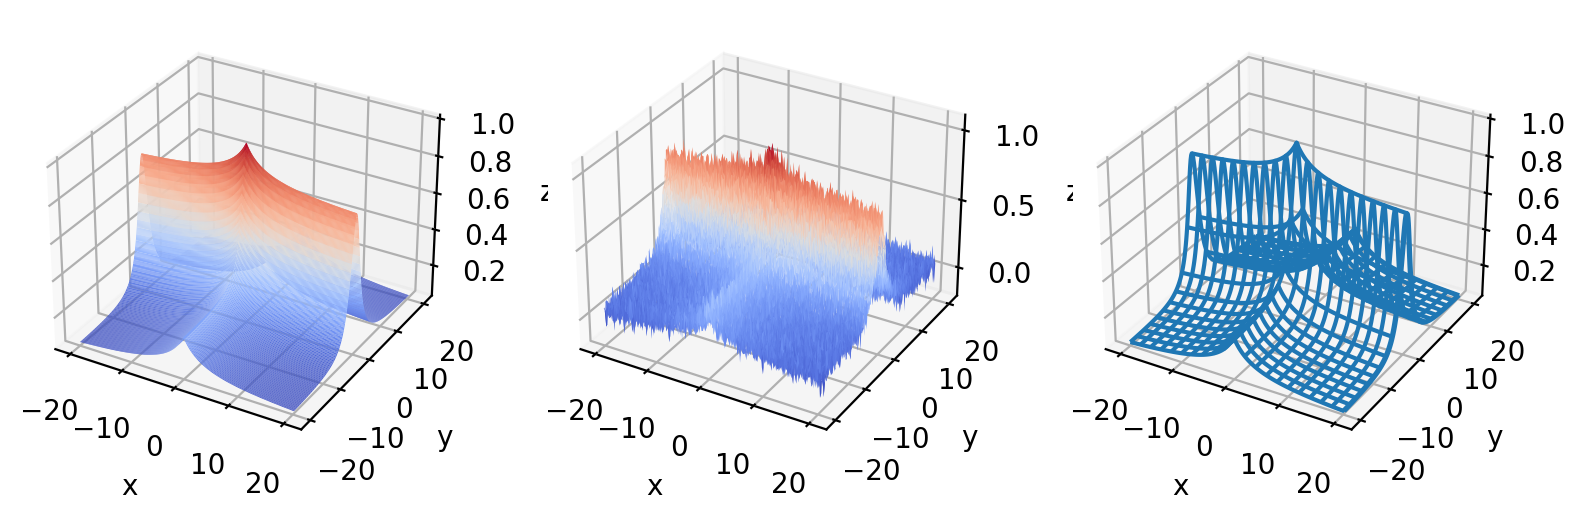

In [ ]:
X = torch.arange(-20, 20.25, 0.2)
Y = torch.arange(-20, 20.25, 0.2)
X, Y = torch.meshgrid(X, Y, indexing='xy')

Z = f(X,Y)

fig = plt.figure(figsize=plt.figaspect(0.5), dpi=200)

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

noise = torch.randn(Z.shape) / 20 # генерация шумов
Z_noise = Z + noise
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot_surface(X, Y, Z_noise, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax = fig.add_subplot(1, 3, 3, projection='3d')

ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

print(type(Z))

In [ ]:
X1, Y1 = X.flatten(), Y.flatten() # приводим к одномерному массиву
Z1 = f(X1, Y1)
noise = torch.randn(Z1.shape) / 20 # генерация шумов
Z1 = Z1 #+ noise

In [ ]:
Xd = torch.stack([X1, Y1], dim=1)
Xd.shape

torch.Size([40804, 2])

In [ ]:
Zd = Z1.reshape(-1, 1)
Zd.shape

torch.Size([40804, 1])

**Тренировка модели**

*Определение места выполнения*

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


*Оптимизатор*

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

*Обучение*

In [ ]:
batch_size = 100 # Размер батча

loss = L1Loss(reduction = 'mean')
loss_dt = loss(model.forward(Xd), Zd) # посчитаем первоначальный лосс
epoch = 0 # Эпоха
check_optim = False # регулировка скорости обучения

model.to(device) # переводим модель на нужный нам девайс

while loss_dt.item() > 0.000406: # 0.0015:
    epoch += 1
    order = torch.randperm(Xd.shape[0]) # перемешиваем значения на входе

    for start_index in range(0, Xd.shape[0], batch_size):

        optimizer.zero_grad() # обнуляем градиент
        batch_indexes = order[start_index:start_index+batch_size] # берем индексы для батча

        if batch_indexes.shape[0] !=batch_size:
            break

        # Выбираем батч
        x_batch = Xd[batch_indexes].to(device)
        z_batch = Zd[batch_indexes].to(device)

        z_pred = model.forward(x_batch) # предсказание

        loss_value = loss(z_pred, z_batch) # считаем лосс
        loss_value.backward() # считаем градиент

        if not check_optim and epoch > 50:
            check_optim = True
            for g in optimizer.param_groups:
                g['lr'] = 1.0e-3

        optimizer.step() # делаем шаг градиента

    test_preds = model.forward(Xd)
    loss_dt = loss(test_preds, Zd)

    if epoch % 100 == 0:
        print(loss_dt)

    # Выход, если прям точность упирается в потолок
    if epoch > 10000:
        break

tensor(0.0016, grad_fn=<L1LossBackward0>)


KeyboardInterrupt: 

In [ ]:
model.eval()
model.to("cpu")

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=11, bias=True)
  (3): Tanh()
  (4): Linear(in_features=11, out_features=1, bias=True)
)

**Предсказание**

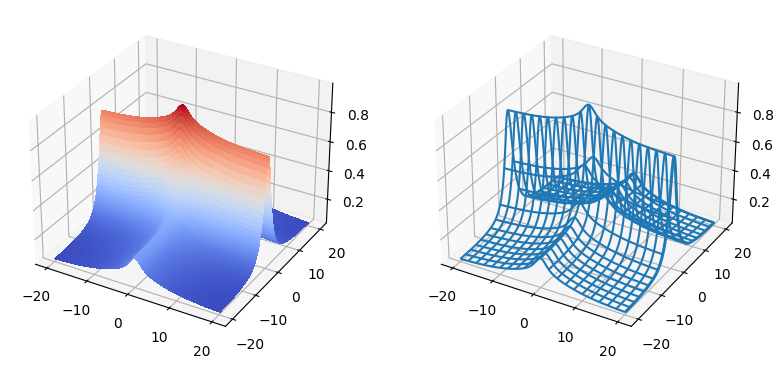

In [ ]:
fig_2 = plt.figure(figsize=plt.figaspect(0.5))

ax_2 = fig_2.add_subplot(1, 2, 1, projection='3d')
X = torch.arange(-20, 20.25, 0.2)
Y = torch.arange(-20, 20.25, 0.2)

# Z = z.test(np.array([X,Y]))
X, Y = torch.meshgrid(X, Y, indexing='xy')

Z = model.forward(Xd).detach().numpy().reshape(202, 202)

ax_2.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax_2 = fig_2.add_subplot(1, 2, 2, projection='3d')

ax_2.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

**Сохранение модели в файл**

In [ ]:
# model.eval()
is_save = False
if is_save:
    torch.save(model, "./models_lab3/model37.pt")
    # torch.save(model.state_dict(), "./models_lab3/model37.pt")

In [ ]:
model_from_file = torch.load("./models_lab3/model37.pt")
# model_from_file = model(*args, **kwargs) # model - нужно название класса
# model_from_file.load_state_dict(torch.load("./models_lab3/model37.pt"))

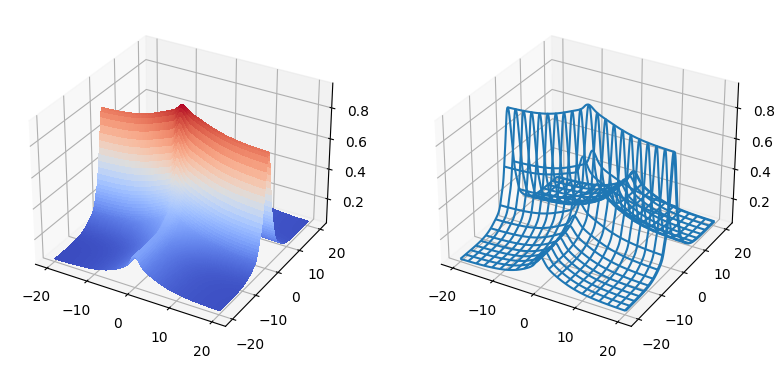

In [ ]:
fig_2 = plt.figure(figsize=plt.figaspect(0.5))

ax_2 = fig_2.add_subplot(1, 2, 1, projection='3d')
X = torch.arange(-20, 20.25, 0.2)
Y = torch.arange(-20, 20.25, 0.2)

# Z = z.test(np.array([X,Y]))
X, Y = torch.meshgrid(X, Y, indexing='xy')

Z = model_from_file.forward(Xd).detach().numpy().reshape(202, 202)

ax_2.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax_2 = fig_2.add_subplot(1, 2, 2, projection='3d')

ax_2.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

**Вывод**

В ходе лабораторной работы изучили принципы построение однослойных и многослойных нейросетей с помощью фреймворка pytorch, а также обучили модели для апроксимации исходной функции.

**Вывод**

В ходе лабораторной работы изучили принципы построение однослойных и многослойных нейросетей с помощью фреймворка pytorch, а также обучили модели для апроксимации исходной функции.Также создали и обучили модель нейросети с помощью фреймворка pytorch для предсказания целевого параметра.